In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pygments.styles.gh_dark import BLUE_1
%matplotlib inline

In [2]:
# Read a list of 32000 names
words = open('names.txt').read().splitlines()
len(words)

32033

## Bigrams

A bigram is a sequence of 2 letters that appear sequentially. For example in the name "Eric" we have (Er, ri, ic). We'll use the frequency of the bigrams to predict what is the most probable next letter in a random name.

In [3]:
# Contain the list of bigram with the number of occurrences
b = {}

# Extract all the bigrams from the list of names
for w in words:
    # We add 2 magic characters to define the beginning and end of the word
    # so we know which character is most likely to be at the beginning and end of the word
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        b[(ch1, ch2)] = b.get((ch1, ch2), 0) + 1

# Sort the bigrams by the count in reverse order (more occurrences first)
sorted(b.items(), key=lambda x: x[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

## PyTorch

We'll store the information of our bigrams in a 2 dimensional array where the first dimension (x) is the first character and the second (y) is the second character. To do that we'll use PyTorch tensor.

In [4]:
chars = sorted(list(set(''.join(words))))
# Lookup table for each character returning the index of the character
stoi = {s: i+1 for i, s in enumerate(chars)}
# Add magic characters
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [5]:
# Create a tensor of 27 by 27 dimension
N = torch.zeros((27, 27), dtype=torch.int32)

# Extract all the bigrams from the list of names
for w in words:
    # We add 2 magic characters to define the beginning and end of the word
    # so we know which character is most likely to be at the beginning and end of the word
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

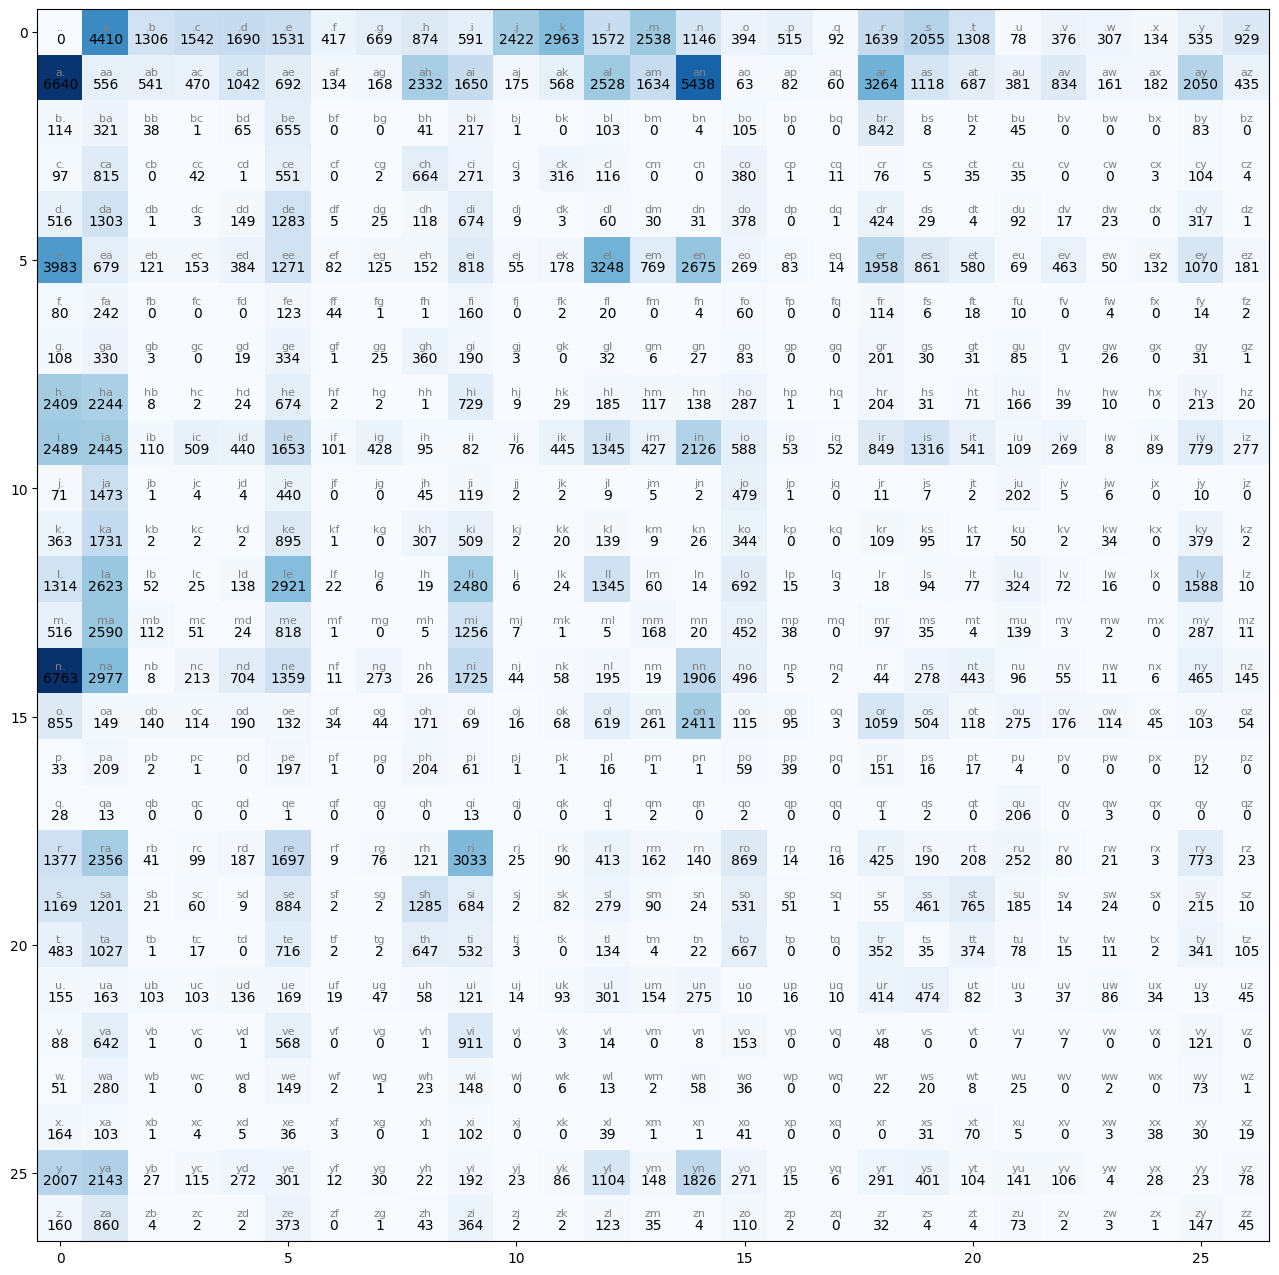

In [6]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', fontsize=8, color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', fontsize=10, color='black')


In [7]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [8]:
g = torch.Generator().manual_seed(2147483647)
# Multinomial sampling, picks one sample in p from the multinomial distribution
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [9]:
g = torch.Generator().manual_seed(2147483647)
r = torch.rand(3, generator=g)
r

tensor([0.7081, 0.3542, 0.1054])

## Broadcasting

This is an optimization. We create a tensor of probability instead of recalculating the probabilities every time.

- [ ] Review what exactly is [Broadcasting](https://docs.pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html#in-brief-tensor-broadcasting) and how it applies to both Numpy and PyTorch

In [10]:
# Tensor Broadcasting, we copy N to P as float values
# We use float here because in N we have counts so integer, but here we want probabilities
# What we also do here is model smoothing. By adding 1 to all counts, we also remove all possibility of having zeroes, or infinitely small log likelihood.
P = (N+1).float()
# This is broadcasting, we collapse the tensor on a single dimension, and we tell PyTorch to keep the dimension.
P /= P.sum(dim=1, keepdim=True)

In [11]:
g = torch.Generator().manual_seed(2147483647)

# Generate 5 names with our model
for i in range(5):
    ix = 0
    name = ''
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        name += itos[ix]
        if ix == 0: break

    print(name[:-1])

cexze
momasurailezitynn
konimittain
llayn
ka


## Loss function

The loss function, as we saw in micrograd, is a way to evaluate the quality of the model. How do we evaluate the quality of a model? By comparing its output with pre-selected expected values.

We'll compile all the probabilities of the model into a single model. The product of all the probabilities is the likelihood and we use the negative log likelihood to have a value from 0 to something higher. We then average this number to obtain the loss value.

The goal of a model is to maximize the likelihood. In our case here we have a static model where we calculated probabilities and they won't change, but later we'll replace this with a neural network and weights that we can influence.

Maximizing the likelihood =
Maximizing the log likelihood =
Minimizing the negative log likelihood =
Minimizing the negative log likelihood


In [12]:
log_likelihood = 0
n = 0

for w in words:
#for w in ['olivia']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        # Get the log of the probability and add it to log likelihood
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob :.4f}, {logprob :.4f}')

print(f'Log likelihood: {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative log likelihood: {nll:.4f}')
print(f'Average log likelihood: {nll / n:.4f}')

Log likelihood: -559951.5625
Negative log likelihood: 559951.5625
Average log likelihood: 2.4544


## Part 2: The Neural Network

In [59]:
xs, ys = [], []

# We create the input and output (label) tensors
# The label tensor will later be useful to calculate the loss
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

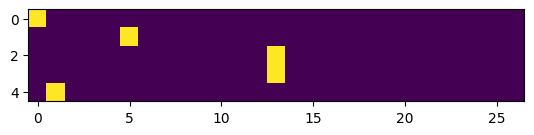

In [14]:
# One hot encoding of the input values,
# because we can't simply pass a tensor of integer to a neural network
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc)

In [28]:
# Create a matrix of weights using a normal distribution of random numbers
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27))
# By doing a simple matrix multiplication we determine the firing rate of a specific input using a dot product
# (5, 27) @ (27, 27) -> (5, 27)
xenc @ W

tensor([[ 4.4459e-01,  2.2817e-01, -1.4135e+00, -1.1647e+00,  7.9693e-01,
          1.4111e-01, -9.4660e-01,  9.5880e-01,  5.2654e-02,  1.6849e+00,
          1.4914e+00,  8.0284e-02, -1.2932e+00, -2.0459e+00,  5.1998e-01,
          3.9977e-01, -2.3554e-01, -2.3508e+00,  1.2089e+00,  4.6345e-04,
          1.2087e+00,  1.2184e-01, -2.5789e-01,  7.1841e-01, -4.8368e-01,
         -9.6645e-01, -4.0376e-01],
        [-5.8216e-01,  9.4816e-01, -1.7662e-01,  9.6154e-01,  1.5782e+00,
          1.1170e+00,  3.3803e-01, -1.5124e-02, -1.1519e+00,  3.1552e+00,
          8.5782e-01, -1.4938e-01,  9.1912e-01,  8.3715e-01,  6.3573e-01,
         -1.9362e+00, -3.5579e-01,  1.2512e+00, -6.6143e-01,  2.3631e+00,
         -1.0402e+00,  1.7579e+00,  2.8454e-01, -1.8002e-01, -2.5083e+00,
         -7.8567e-01,  4.0251e-01],
        [ 1.0380e+00,  1.1158e+00,  9.3452e-01, -2.8637e-01,  5.2763e-01,
         -8.3554e-01, -1.7758e+00,  7.1438e-01,  7.1280e-01, -2.3487e-01,
          1.2247e+00, -5.0679e-01,  1.74

In [20]:
# If we do a simple multiplication of the encoding we can see most number are zero except the one we are interested in
xenc[3] * W[:, 13]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.9886,  0.0000, -0.0000,
        -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0000, -0.0000])

In [22]:
# By summing the vector, we receive the single value we are interested in
(xenc[3] * W[:, 13]).sum()

tensor(-0.9886)

In [23]:
# We can see that this matches our matrix multiplication at the same coordinates
(xenc @ W)[3, 13]

tensor(-0.9886)

### Softmax

In [26]:
# Because we have used randn to create our weights matrix, we can have negative numbers in the output
# Exponentiating the output to have only positive numbers so we can interpret them as probabilities
logits = xenc @ W
counts = logits.exp()
# Normalize the counts to get a probability distribution
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0382, 0.0116, 0.0133, 0.0085, 0.0085, 0.0063, 0.0080, 0.1085, 0.0342,
         0.0659, 0.0253, 0.0192, 0.0137, 0.1756, 0.0185, 0.1456, 0.0808, 0.0452,
         0.0094, 0.0462, 0.0438, 0.0164, 0.0087, 0.0140, 0.0129, 0.0148, 0.0072],
        [0.0778, 0.0084, 0.0193, 0.0148, 0.1562, 0.0074, 0.0440, 0.0205, 0.0310,
         0.0122, 0.0427, 0.0078, 0.0086, 0.0484, 0.0080, 0.0561, 0.0176, 0.1771,
         0.0064, 0.0498, 0.0061, 0.0312, 0.0069, 0.0220, 0.0706, 0.0413, 0.0076],
        [0.0338, 0.0447, 0.0213, 0.0262, 0.0052, 0.0327, 0.0314, 0.0550, 0.0115,
         0.0150, 0.0038, 0.0165, 0.0348, 0.0113, 0.0384, 0.1196, 0.0158, 0.0863,
         0.0690, 0.0522, 0.0578, 0.0469, 0.0125, 0.0046, 0.0289, 0.0812, 0.0436],
        [0.0338, 0.0447, 0.0213, 0.0262, 0.0052, 0.0327, 0.0314, 0.0550, 0.0115,
         0.0150, 0.0038, 0.0165, 0.0348, 0.0113, 0.0384, 0.1196, 0.0158, 0.0863,
         0.0690, 0.0522, 0.0578, 0.0469, 0.0125, 0.0046, 0.0289, 0.0812, 0.0436],
        [0.0967, 0.0040,

## The Real Thing: Optimization

In [87]:
# Initialize the matrix
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
num = xs.nelement()
print(num)

228146


In [103]:
# Gradient descent
learning_rate = 50
for k in range(100):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean() # Loss regularization
    print(loss.item())

    # Backward pass
    W.grad = None
    loss.backward()

    # Update
    W.data += -learning_rate * W.grad

2.4821622371673584
2.4821507930755615
2.4821388721466064
2.4821274280548096
2.4821157455444336
2.482104539871216
2.482093334197998
2.482081890106201
2.4820713996887207
2.482060432434082
2.4820494651794434
2.482038736343384
2.4820282459259033
2.4820175170898438
2.4820070266723633
2.481996536254883
2.4819867610931396
2.4819765090942383
2.481966257095337
2.4819564819335938
2.4819464683532715
2.4819366931915283
2.481926918029785
2.481917142868042
2.481907367706299
2.481898069381714
2.481888771057129
2.481879234313965
2.481870174407959
2.481861114501953
2.4818520545959473
2.4818429946899414
2.4818339347839355
2.481825351715088
2.481816291809082
2.4818077087402344
2.481799364089966
2.481790542602539
2.4817819595336914
2.4817733764648438
2.4817655086517334
2.481757164001465
2.481748580932617
2.4817404747009277
2.4817326068878174
2.481724500656128
2.4817166328430176
2.4817087650299072
2.4817006587982178
2.4816932678222656
2.4816856384277344
2.481677770614624
2.481670379638672
2.481662750244140

In [112]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        # Encode the input, starting from 0
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        # Process the input with our model
        logits = xenc @ W
        # Transform to probabilities
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        # Multinomial sampling
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out[:-1]))

cexze
momasurailezityha
konimittain
llayn
ka


In [107]:
# previous results, using static probability matrix:
cexze
momasurailezitynn
konimittain
llayn
ka

NameError: name 'cexze' is not defined